In [9]:
import jax
import jax.numpy as jnp
import genjax
from genjax import grasp
import matplotlib.pyplot as plt
from functools import reduce
from jax.scipy.special import logsumexp

In [10]:
console = genjax.pretty()

In [11]:
# from https://github.com/mattjj/svae/blob/master/experiments/gmm_svae_synth.py
def make_pinwheel_data(
    key, radial_std, tangential_std, num_classes, num_per_class, rate
):
    keys = jax.random.split(key, 2)
    rads = jnp.linspace(0, 2 * jnp.pi, num_classes, endpoint=False)

    features = jax.random.normal(keys[0], (num_classes * num_per_class, 2)) * jnp.array(
        [radial_std, tangential_std]
    )
    features = features.at[:, 0].add(1.0)
    labels = jnp.repeat(jnp.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * jnp.exp(features[:, 0])
    rotations = jnp.stack(
        [jnp.cos(angles), -jnp.sin(angles), jnp.sin(angles), jnp.cos(angles)]
    )
    rotations = jnp.reshape(rotations.T, (-1, 2, 2))

    return 10 * jax.random.permutation(
        keys[1], jnp.einsum("ti,tij->tj", features, rotations)
    )

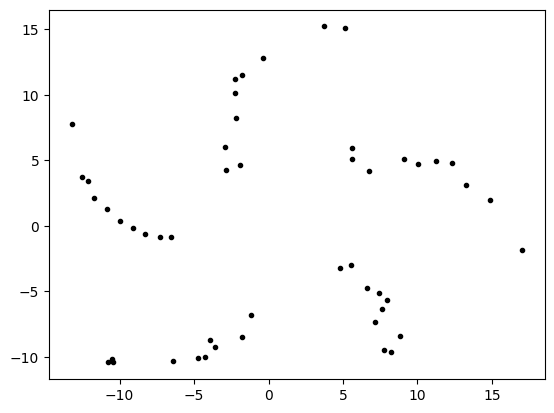

In [12]:
NUM_CLUSTERS = 5
POINTS_PER_CLUSTER = 10
N = NUM_CLUSTERS * POINTS_PER_CLUSTER
pinwheel = make_pinwheel_data(
    jax.random.PRNGKey(0), 0.3, 0.05, NUM_CLUSTERS, POINTS_PER_CLUSTER, 0.25
)
plt.scatter(pinwheel[:, 0], pinwheel[:, 1], marker=".", c="black")

---

In [13]:
mlp = lambda x, ws: reduce(lambda z, w: jax.nn.leaky_relu(w @ z), ws, x)
matsqr = lambda x: x @ x
toprob = lambda logits: jnp.exp(logits - logsumexp(logits))

In [15]:
@genjax.gen
def model(params):
    for i in range(N):
        z = grasp.categorical_enum(toprob(params["logits"])) @ ("z", i)
        cluster_mean = jax.lax.dynamic_index_in_dim(params["means"], z, keepdims=False)
        cluster_scale = jax.lax.dynamic_index_in_dim(
            params["scales"], z, keepdims=False
        )
        x = grasp.mv_normal_diag_reparam(cluster_mean, cluster_scale) @ ("x", i)
        point_mean = mlp(x, params["mean_ws"])
        point_scale = mlp(x, params["scale_ws"]).reshape(2, 2)
        grasp.mv_normal_diag_reparam(point_mean, matsqr(point_scale)) @ ("y", i)

In [16]:
key = jax.random.PRNGKey(0)
model_params = {
    "logits": jnp.ones(NUM_CLUSTERS),
    "means": jnp.arange(2 * NUM_CLUSTERS, dtype=jnp.float32).reshape(NUM_CLUSTERS, 2),
    "scales": jnp.ones((NUM_CLUSTERS, 2, 2)),
    "mean_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (2, 10)),
    ),
    "scale_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (4, 10)),
    ),
}

In [17]:
key = jax.random.split(key)[0]
model.simulate(key, (model_params,)).strip();

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 key = jax.random.split(key)[0]                                                               │
│ ❱ 2 model.simulate(key, (model_params,)).strip();                                                │
│   3                                                                                              │
│ in simulate:50                                                                                   │
│                                                                                                  │
│ /home/femtomc/Research/genjax/src/genjax/_src/generative_functions/builtin/builtin_gen_fn.py:173 │
│ in simulate                                                                                      │
│                                                                                                  │
│   170 │   │   key: PRNGKey,                                                                      │
│   171 │   │   args: Tuple,                                                                       │
│   172 │   ) -> BuiltinTrace:                                                                     │
│ ❱ 173 │   │   (f, args, r, chm, score), cache = simulate_transform(self.source)(key, args)       │
│   174 │   │   return BuiltinTrace.new(self, args, r, chm, cache, score)                          │
│   175 │                                                                                          │
│   176 │   @dispatch                                                                              │
│                                                                                                  │
│ /home/femtomc/Research/genjax/src/genjax/_src/generative_functions/builtin/builtin_transforms.py │
│ :184 in wrapper                                                                                  │
│                                                                                                  │
│   181 │   @functools.wraps(source_fn)                                                            │
│   182 │   def wrapper(key, args):                                                                │
│   183 │   │   ctx = SimulateContext.new(key)                                                     │
│ ❱ 184 │   │   retvals, statefuls = context.transform(source_fn, ctx)(*args, **kwargs)            │
│   185 │   │   constraints, cache, score = statefuls                                              │
│   186 │   │   return (source_fn, args, retvals, constraints, score), cache                       │
│   187                                                                                            │
│                                                                                                  │
│ /home/femtomc/Research/genjax/src/genjax/_src/core/interpreters/context.py:448 in wrapped        │
│                                                                                                  │
│   445 │   │   │   flat_args, in_tree = jtu.tree_flatten(args)                                    │
│   446 │   │   │   flat_fun, out_tree = api_util.flatten_fun_nokwargs(fun, in_tree)               │
│   447 │   │   │   flat_fun = _transform(flat_fun, trace_type, main, ctx)                         │
│ ❱ 448 │   │   │   out_flat, ctx_statefuls = flat_fun.call_wrapped(flat_args)                     │
│   449 │   │   │   del main                                                                       │
│   450 │   │   return jtu.tree_unflatten(out_tree(), out_flat), ctx_statefuls                     │
│   451                                                                                            │
│                                                            

In [ ]:
@genjax.gen
def variational_family(data, params):
    for i in range(N):
        cluster_mean = mlp(data[("y", i)], params["mean_ws"])
        cluster_scale = mlp(data[("y", i)], params["scale_ws"]).reshape(2, 2)
        x = grasp.mv_normal_reparam(cluster_mean, matsqr(cluster_scale)) @ ("x", i)
        z = grasp.categorical_enum(toprob(mlp(x, params["cat_ws"]))) @ ("z", i)

In [ ]:
vf_params = {
    "mean_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (2, 10)),
    ),
    "scale_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (4, 10)),
    ),
    "cat_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (NUM_CLUSTERS, 10)),
    ),
}

In [ ]:
pinwheel_data = genjax.choice_map({("y", i): pinwheel[i, :] for i in range(N)})
key = jax.random.split(key)[0]
variational_family.simulate(key, (pinwheel_data, vf_params));

In [ ]:
loss = grasp.elbo(model, variational_family, pinwheel_data)

In [ ]:
loss.value_and_grad_estimate(key, ((model_params,), (pinwheel_data, vf_params)))